# Lonlat ms diagnosis on main combination

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms



import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

import histlib.matchup as match
import histlib.diagnosis as diag
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part, global_cor
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
dl=5
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'

id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_alti_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

var = list(id_co_dic.values())+list(id_aviso_dic.values())+['nb_coloc_bin']+['sum_'+v for v in [id_aviso, id_co]]+['sum_'+v for v in [id_aviso, id_co]]+['exc_acc_'+v for v in [id_aviso, id_co]]+['exc_coriolis_'+v for v in [id_aviso, id_co]]+['exc_ggrad_'+v for v in [id_aviso, id_co]]+['exc_wind_'+v for v in [id_aviso, id_co]]

# Datasets 

In [3]:
files_ms = glob(os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files_ms = [f for f in files_ms if 'gps' in f]
files_mean = glob(os.path.join(zarr_dir+'_ok',f'meanlonlat/meanlonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files_mean = [f for f in files_mean if 'gps' in f]
files_corr = glob(os.path.join(zarr_dir+'_ok',f'corrlonlat/corrlonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files_corr = [f for f in files_corr if 'gps' in f]

In [4]:
dsms = xr.open_mfdataset(files_ms)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dsmean = xr.open_mfdataset(files_mean)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dscorr = xr.open_mfdataset(files_corr).rename({'nb_coloc_bin':'nb_coloc'}).compute()

In [5]:
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' (latbin: 36, lonbin: 72)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  3., 12., ...,  8.,  0., 13.],
       ...,
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * latbin   (latbin) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lonbin   (lonbin) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5


In [6]:
dsc = -2 * global_cor(dscorr)# balanced contribution
dsc

<xarray.DataArray 'nb_coloc' (latbin: 36, lonbin: 72)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  3., 12., ...,  8.,  0., 13.],
       ...,
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * latbin   (latbin) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lonbin   (lonbin) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5


<xarray.Dataset>
Dimensions:                                                                              (
                                                                                          latbin: 36,
                                                                                          lonbin: 72)
Coordinates:
  * latbin                                                                               (latbin) float64 ...
  * lonbin                                                                               (lonbin) float64 ...
Data variables: (12/45)
    prod_alti_ggx_adt_filtered__es_cstrio_z15_alti_wd_x                                  (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered__es_cstrio_z15_drifter_wd_x                               (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide__es_cstrio_z15_alti_wd_x                       (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide__es_cstrio_z15_drifter_wd_x                    (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide_internal_tide__es_cstrio_z15_alti_wd_x         (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide_internal_tide__es_cstrio_z15_drifter_wd_x      (latbin, lonbin) float64 ...
    ...                                                                                   ...
    prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide_dac       (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__aviso_alti_ggx_adt                                       (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__aviso_drifter_ggx_adt                                    (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__es_cstrio_z15_alti_wd_x                                  (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__es_cstrio_z15_drifter_wd_x                               (latbin, lonbin) float64 ...
    nb_coloc                                                                             (latbin, lonbin) float64 ...

______________________
# Fig function

In [199]:
def put_fig_letter(ax, letter):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

def plot_total_lonlat_hist(var, ax) :
    v = var.values.ravel()
    v = v[~np.isnan(v)]
    hist, bedge = np.histogram(v, bins=100)
    ax.plot(bedge[:-1] + (bedge[1]-bedge[0])/2, hist)

def plot_lonlat(var,ax, letter,**kwargs):
    var.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), **kwargs)
    put_fig_letter(ax, letter)
    ins = ax.inset_axes(ins_ax_box)
    plot_total_lonlat_hist(var, ins)
    ins.grid()
    ins.set_yticks([])
    ins.set_xlabel('')
    bbox = dict(ec="w", fc="w", alpha=0.8)
    plt.setp(ins.get_xticklabels(), bbox=bbox)
    ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')
    ins.xaxis.get_offset_text().set(bbox=bbox)


In [172]:
ins_ax_box = [0.66,0.73,0.25,0.27]

______________________
# Count

In [173]:
min_coloc_bin = 30
ds['nb_coloc'].attrs = {'long_name': 'Number of colocations per bin'}

Text(0.5, 0.8, 'Distribution')

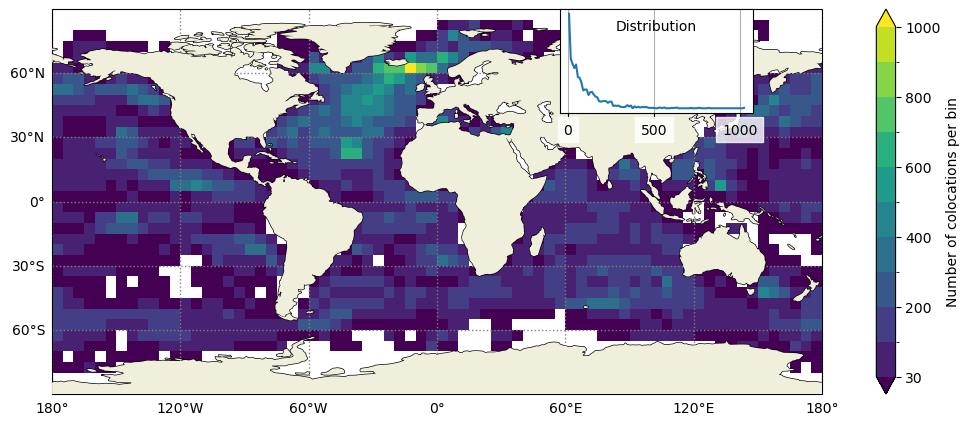

In [192]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ds.where(ds.nb_coloc> 0).nb_coloc.plot(x='lonbin', y='latbin', cmap='viridis', levels=[min_coloc_bin]+list(np.arange(100, 1100, 100)), ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=1, linestyle=':', zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False

ins = ax.inset_axes(ins_ax_box)
plot_total_lonlat_hist(ds.where(ds.nb_coloc> 0).nb_coloc, ins)
bbox = dict(ec="w", fc="w", alpha=0.8)
plt.setp(ins.get_xticklabels(), bbox=bbox)



ins.grid()
ins.set_yticks([])
ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')

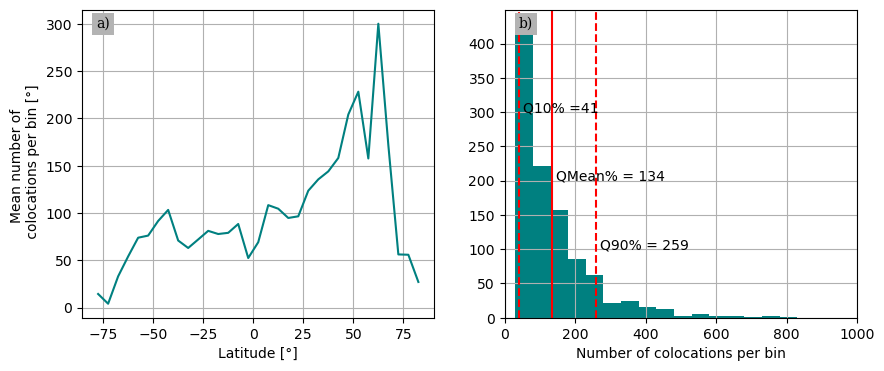

In [175]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax=axs[0]
ds.where(ds.nb_coloc> 0).nb_coloc.mean('lonbin').plot(ax=ax, c='teal')
ax.set_xlabel('Latitude [°]')
ax.set_ylabel('Mean number of \n colocations per bin [°]')
ax.grid()
put_fig_letter(ax, 'a')

ax =axs[1]
dd = 10
_ds = ds.where(ds.nb_coloc> min_coloc_bin).nb_coloc
hist = _ds.plot.hist(bins=np.arange(30,4000, 50), ax=ax, color='teal')
mean = _ds.mean().values
q90 = _ds.quantile(0.9).values
q10 = _ds.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_xlim(0, 1000)
put_fig_letter(ax, 'b')

(0.0, 1000.0)

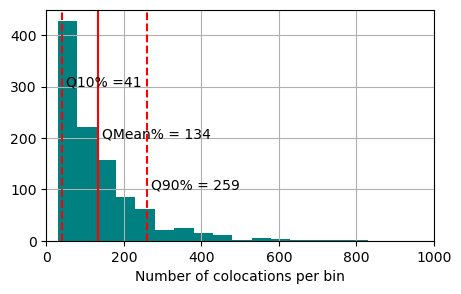

In [176]:
dd = 10
_ds = ds.where(ds.nb_coloc> min_coloc_bin).nb_coloc
fig, ax = plt.subplots(1,1, figsize=(5,3))
hist = _ds.plot.hist(bins=np.arange(30,4000, 50), ax=ax, color='teal')
mean = _ds.mean().values
q90 = _ds.quantile(0.9).values
q10 = _ds.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_xlim(0, 1000)

(0.0, 1000.0)

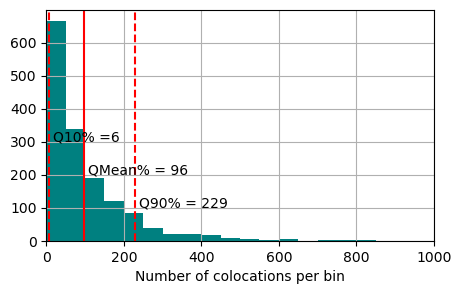

In [177]:
dd = 10
_ds = ds.where(ds.nb_coloc >0).nb_coloc
fig, ax = plt.subplots(1,1, figsize=(5,3))
hist = _ds.plot.hist(bins=np.arange(0,4000, 50), ax=ax, color='teal')
mean = _ds.mean().values
q90 = _ds.quantile(0.9).values
q10 = _ds.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_xlim(0, 1000)

______________________
# Closure efficiancy : MSRe and nMSRe

In [224]:
ins_ax_box = [0.56,0.7,0.29,0.3]

In [179]:
test = mserr['sum_'+id_co]/ds['sum_'+id_co]*100<50 # keep only bins where MSRe relative error is below 50%
#test2 = mserr['sum_'+id_aviso]/ds['sum_'+id_aviso]*100<50
#test=test1 & test2
dsm = ds.where(test)
dse=mserr.where(test)

def compute_sum_ms(ds, id_, dic=None):
    if dic == None :
        dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
    
sco = compute_sum_ms(dsm, id_co, id_co_dic)
saviso = compute_sum_ms(dsm, id_aviso, id_aviso_dic)

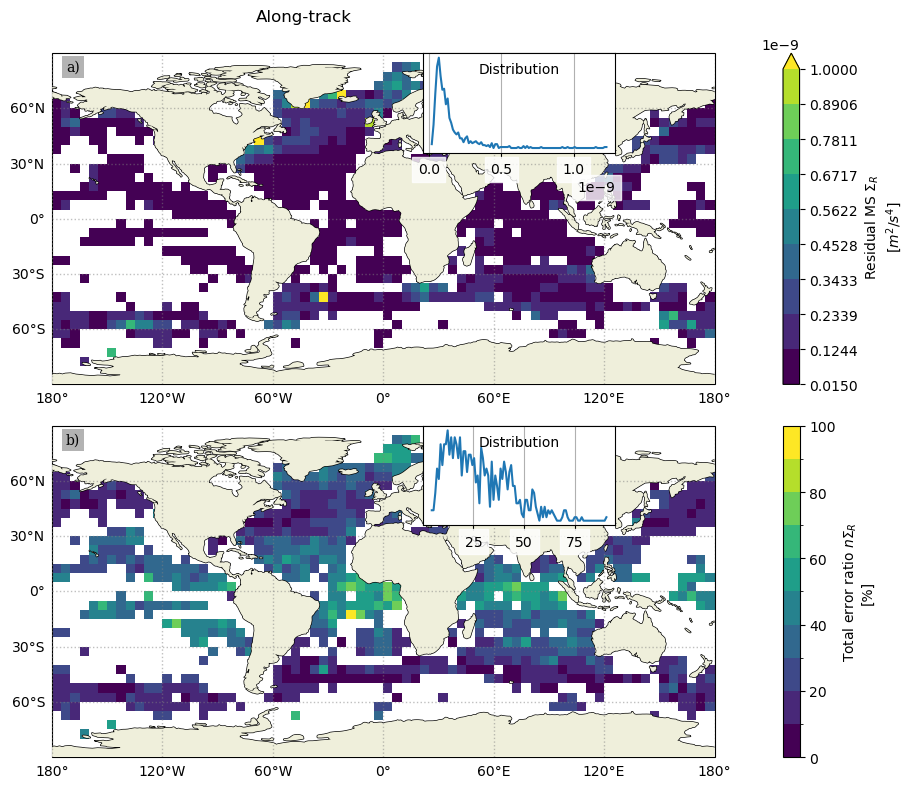

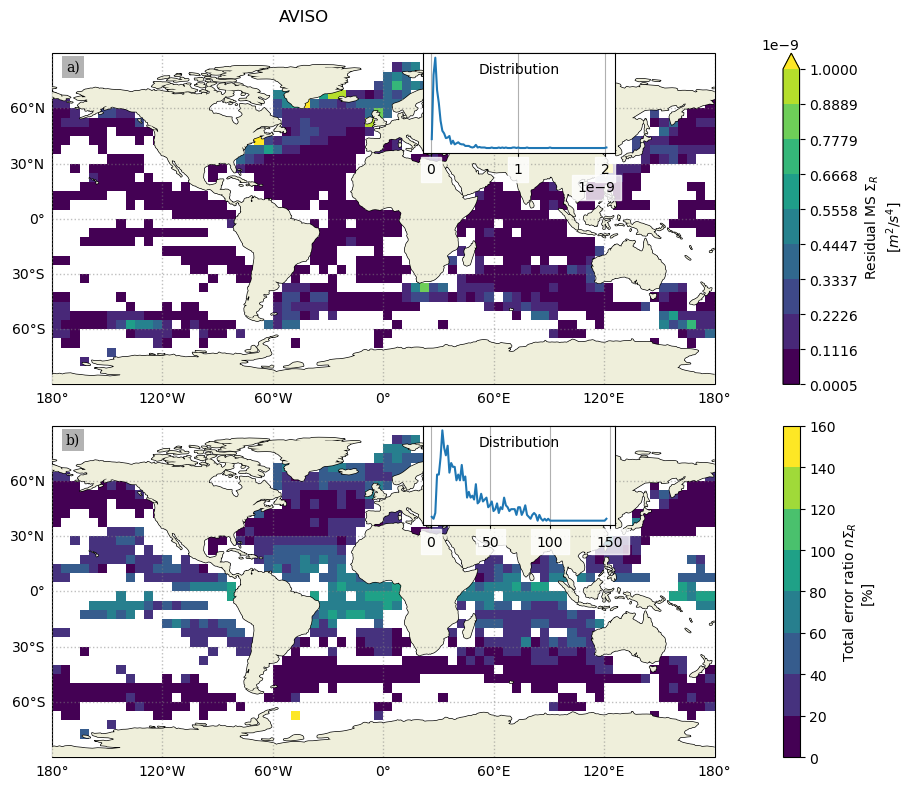

In [225]:
# CO 
fig, axs = plt.subplots(2,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,8))
ax = axs[0]
dsm['sum_'+id_co].attrs = {'long_name':r'Residual MS $\Sigma_R$ $[m^2/s^4]$'}
plot_lonlat(dsm['sum_'+id_co],ax, 'a', vmax = 1e-9, levels=10)

ax = axs[1]
nmsre = (dsm['sum_'+id_co]/sco*100).assign_attrs({'long_name': r'Total error ratio $n\Sigma_R$ [%]'})
plot_lonlat(nmsre,ax, 'b', levels=10)



for ax in axs :
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
fig.suptitle('Along-track')
fig.tight_layout(rect=[0,0,1,1])

# AVISO
fig, axs = plt.subplots(2,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,8), sharex=True, sharey=True)
ax = axs[0]
dsm['sum_'+id_aviso].attrs = {'long_name':r'Residual MS $\Sigma_R$ $[m^2/s^4]$'}
plot_lonlat(dsm['sum_'+id_aviso],ax, 'a', vmax = 1e-9, levels=10)

ax = axs[1]
nmsre = (dsm['sum_'+id_aviso]/saviso*100).assign_attrs({'long_name': r'Total error ratio $n\Sigma_R$ [%]'})
plot_lonlat(nmsre,ax, 'b', levels=10)

for ax in axs :
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=3)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
fig.suptitle('AVISO')
fig.tight_layout(rect=[0,0,1,1])

Text(0.5, 1.0, 'Along-track')

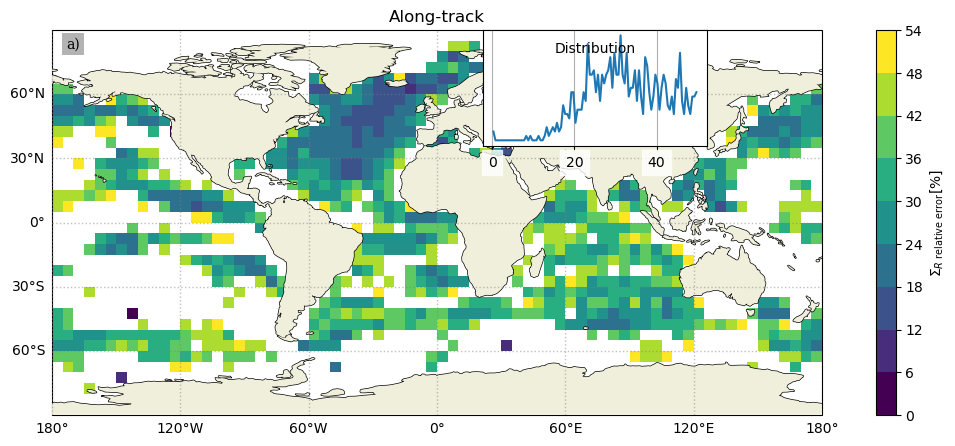

In [226]:
dse=mserr.where(test)
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ne = (dse['sum_'+id_co]/dsm['sum_'+id_co]*100).assign_attrs({'long_name':r'$\Sigma_{R\text{ relative error}}$[%]'})
plot_lonlat(ne, ax, 'a', levels=10)
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title('Along-track')

Text(0.5, 1.0, 'AVISO')

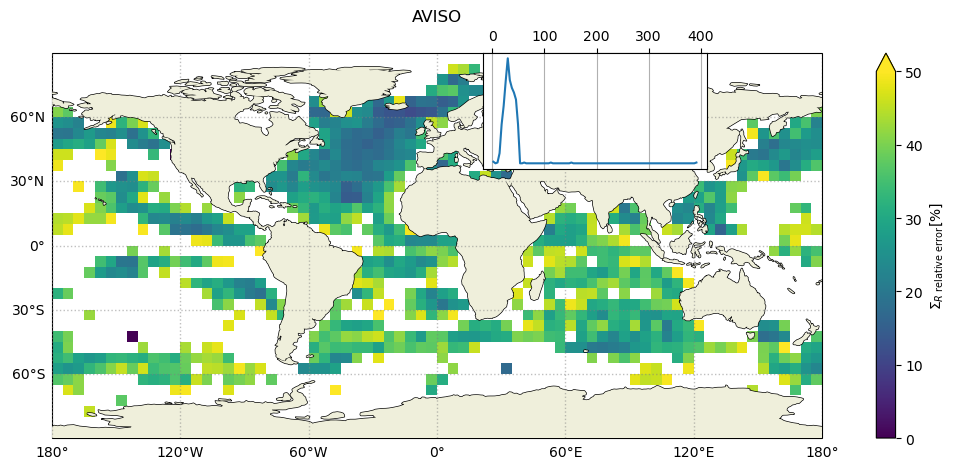

In [227]:
dse=mserr.where(test)
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ne = (dse['sum_'+id_aviso]/dsm['sum_'+id_aviso]*100).assign_attrs({'long_name':r'$\Sigma_{R\text{ relative error}}$[%]'})
ne.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax = 50)
ins = ax.inset_axes(ins_ax_box)
plot_total_lonlat_hist(ne, ins)
ins.grid()
ins.set_yticks([])
ins.set_xlabel('')
ins.xaxis.set_ticks_position('top')

ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title('AVISO')

Text(0.5, 1.0, 'Along-track')

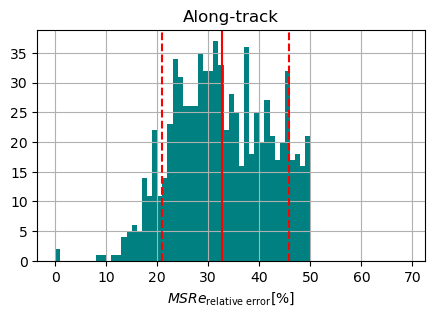

In [31]:
dd = 10
_ds = ds.where(ds.nb_coloc >0).nb_coloc
fig, ax = plt.subplots(1,1, figsize=(5,3))
hist = ne.plot.hist(bins=np.arange(0,70, 1), ax=ax, color='teal')
mean = ne.mean().values
q90 = ne.quantile(0.9).values
q10 = ne.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_title('Along-track')

______________________
# Covariances


In [203]:
import itertools
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

In [204]:
dsc_ = dsc.where(test)

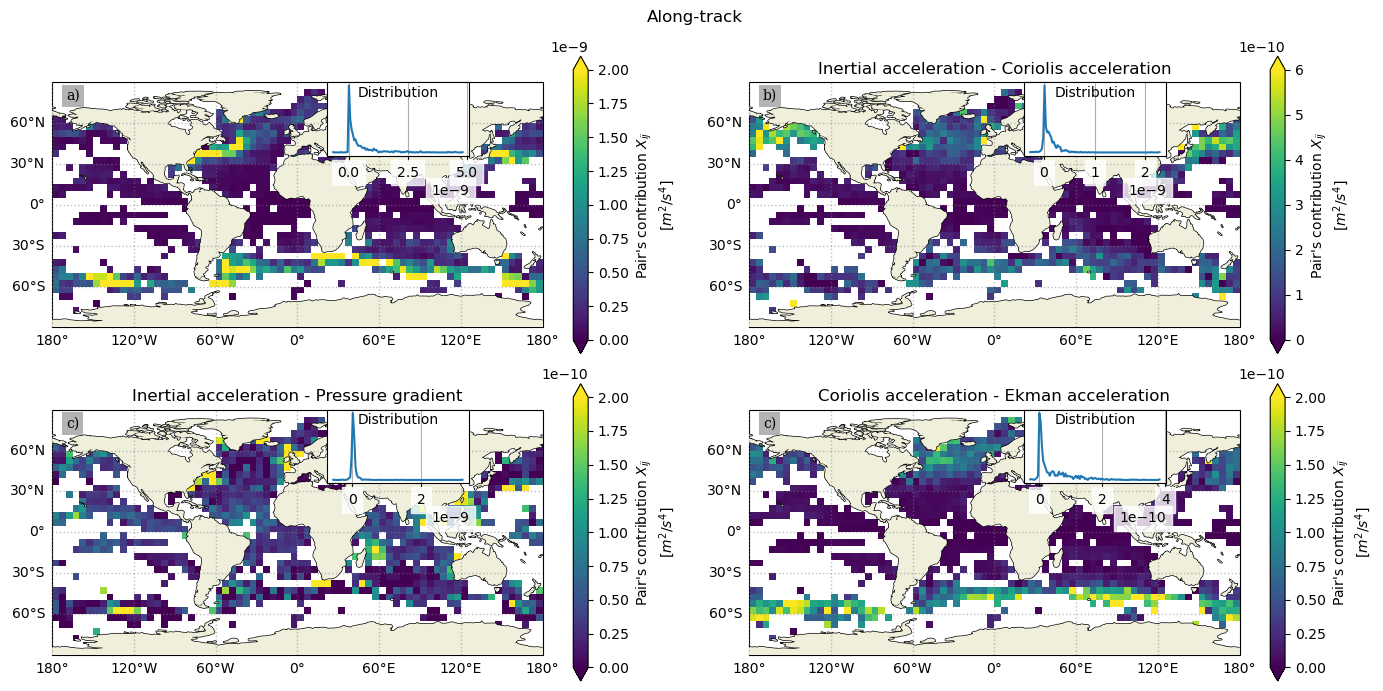

In [228]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True)
title = ['Coriolis - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - Ekman acceleration',]
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
dsc_[corr_var_co[3]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[3]], ax, 'a', vmin = 0, vmax=2e-9,)

ax=axs[1]
dsc_[corr_var_co[0]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[0]], ax, 'b', vmin = 0, vmax=6e-10,)
ax.set_title(title[1])

ax=axs[2]
dsc_[corr_var_co[1]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[1]], ax, 'c', vmin = 0, vmax = 2e-10,)
ax.set_title(title[2])

ax=axs[3]
dsc_[corr_var_co[4]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[4]], ax, 'c', vmin = 0, vmax = 2e-10,)
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)


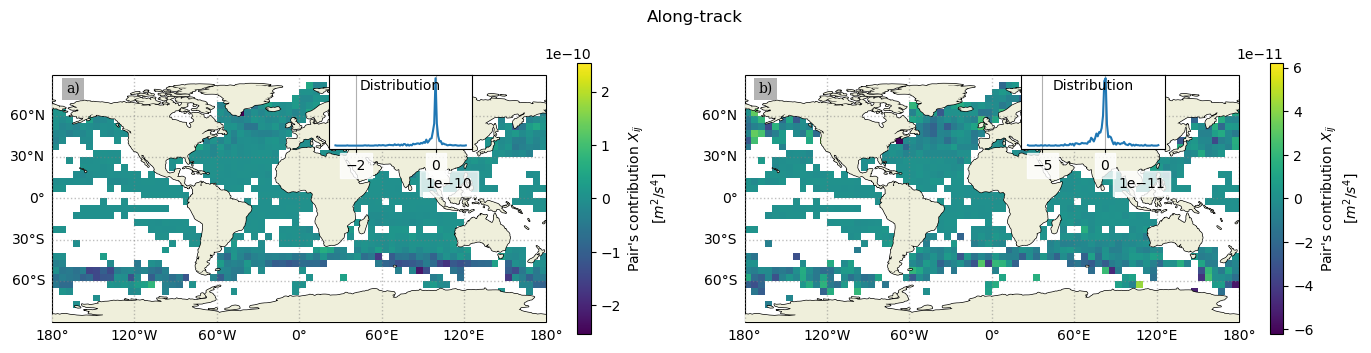

In [230]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,3.5), sharex=True, sharey=True)
title = ['','']
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
dsc_[corr_var_co[5]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[5]], ax, 'a')
ax.set_title(title[0])

ax=axs[1]
dsc_[corr_var_co[2]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[2]], ax, 'b')
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)



## Contribution normalized by $\Sigma$

In [207]:
dsm['sigma_co']=compute_sum_ms(dsm, id_co, id_co_dic)

In [208]:
dscn = dsc_/dsm['sigma_co']*100

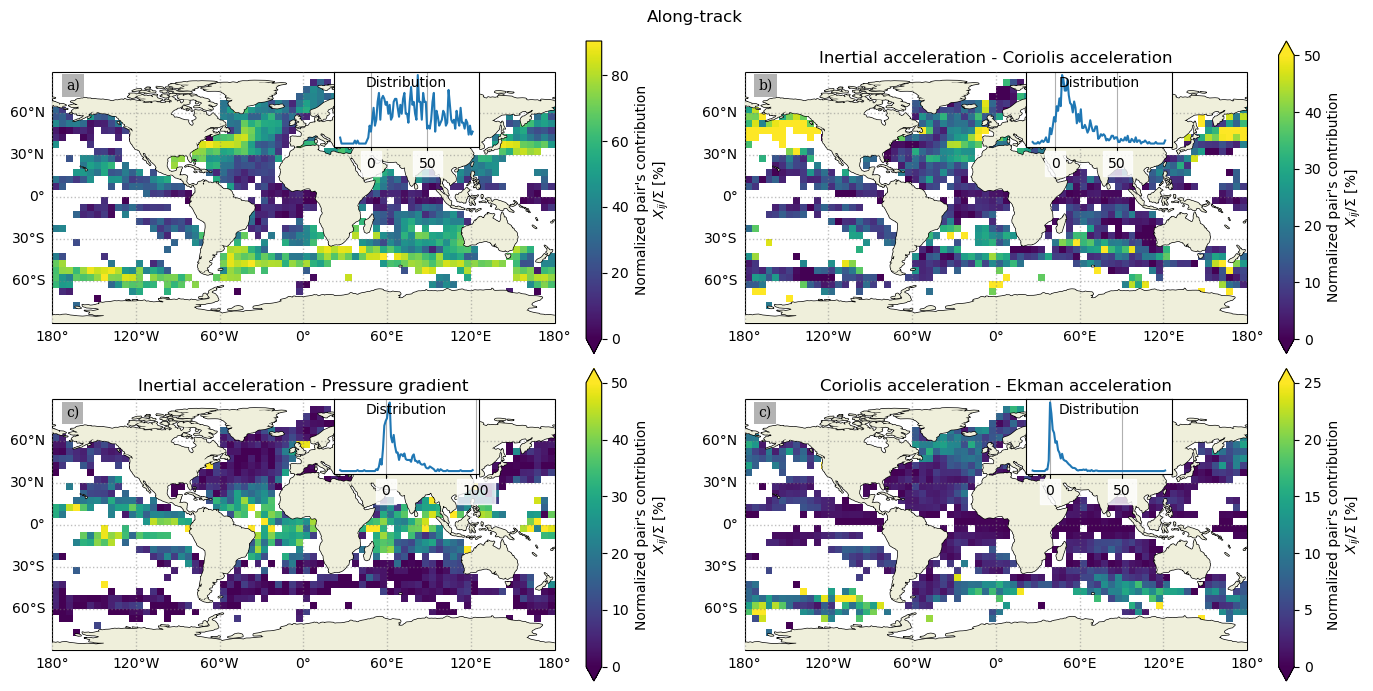

In [231]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True)
title = ['Coriolis - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - Ekman acceleration',]
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
dscn[corr_var_co[3]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[3]], ax, 'a', vmin = 0)

ax=axs[1]
dscn[corr_var_co[0]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[0]], ax, 'b', vmin = 0, vmax=50)
ax.set_title(title[1])

ax=axs[2]
dscn[corr_var_co[1]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[1]], ax, 'c', vmin = 0, vmax=50)
ax.set_title(title[2])

ax=axs[3]
dscn[corr_var_co[4]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[4]], ax, 'c', vmin = 0, vmax=25)
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)


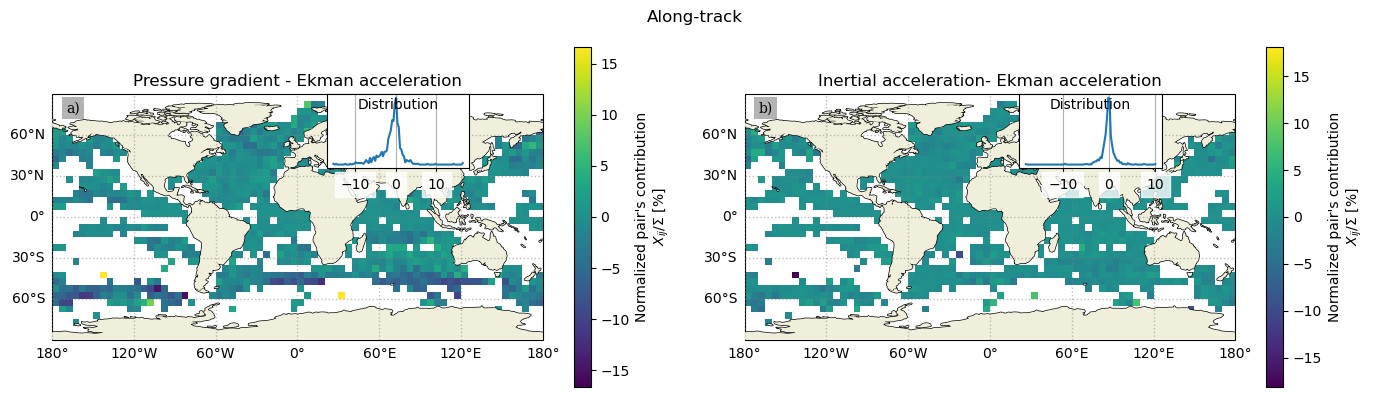

In [233]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,4), sharex=True, sharey=True)
title = ['Pressure gradient - Ekman acceleration','Inertial acceleration- Ekman acceleration']
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
dscn[corr_var_co[5]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[5]], ax, 'a')
ax.set_title(title[0])

ax=axs[1]
dscn[corr_var_co[2]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[2]], ax, 'b')
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)


________________________
# True/Error in $x$ 
$\langle \hat{x_i} \rangle +\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle+\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $
## Under H1

$\langle \hat{x_i} \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $

In [211]:
def true_err_x(ds, id_, dic) :
    dso = xr.Dataset()
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds[X]
        dso['exc_'+x] = ds['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds[X] - ds['sum_'+id_] + ds['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds[X] + ds['sum_'+id_] - ds['exc_' + x +'_'+ id_])/2
    dso['S'] = ds['sum_'+id_]
    return dso
dsmss = xr.concat([true_err_x(dsm, id_co, id_co_dic), true_err_x(dsm, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
for v in ['acc', 'coriolis', 'ggrad', 'wind']: 
    dsmss['true_' + v].attrs ={'long_name':r'Captured physical signal', 'unit':r'$m^2/s^4$'}
    dsmss['err_' + v].attrs ={'long_name':r'Error signal', 'unit':r'$m^2/s^4$'}


In [247]:
dsmssco = dsmss.sel(id_comb =id_co)
s = compute_sum_ms(dsm, id_co, id_co_dic)
dsmssco_s = dsmssco/s*100

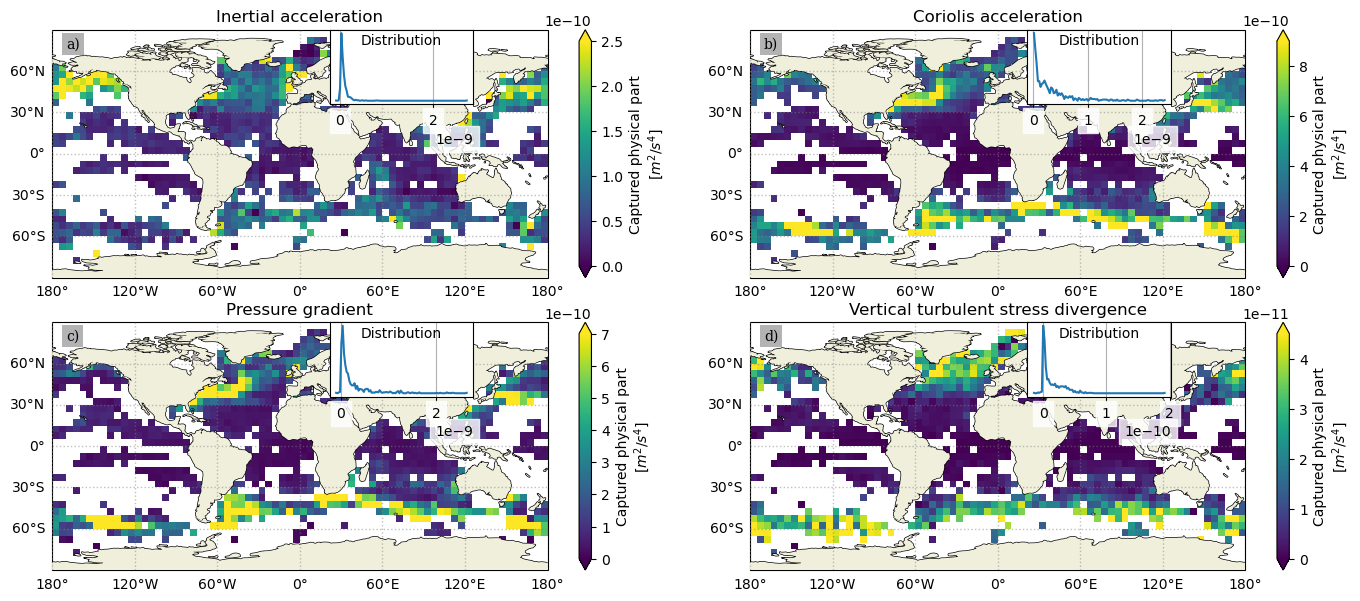

In [241]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True)
axs=axs.flatten()
label = 'Captured physical part'

ax=axs[0]
dsmssco['true_acc'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_acc'], ax, 'a', vmin = 0, vmax=2.5e-10,)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco['true_coriolis'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_coriolis'], ax, 'b', vmin = 0, vmax=9e-10,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco['true_ggrad'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_ggrad'], ax, 'c', vmin = 0, vmax=7e-10,)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco['true_wind'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_wind'], ax, 'd', vmin = 0, vmax=4.5e-11,)
ax.set_title('Vertical turbulent stress divergence')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)


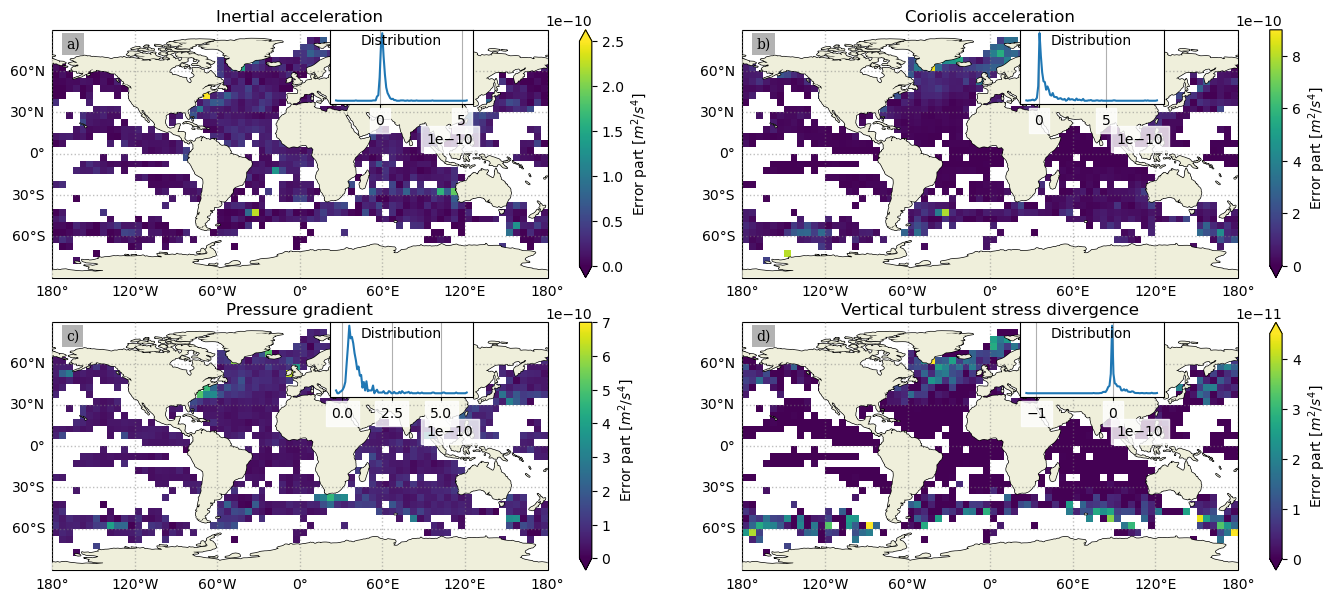

In [242]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True)
axs=axs.flatten()
label = 'Error part'

ax=axs[0]
dsmssco['err_acc'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_acc'], ax, 'a', vmin = 0, vmax=2.5e-10,)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco['err_coriolis'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_coriolis'], ax, 'b', vmin = 0, vmax=9e-10,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco['err_ggrad'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_ggrad'], ax, 'c', vmin = 0, vmax=7e-10,)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco['err_wind'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_wind'], ax, 'd', vmin = 0, vmax=4.5e-11,)
ax.set_title('Vertical turbulent stress divergence')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)


## True/error part normalized by $\Sigma$

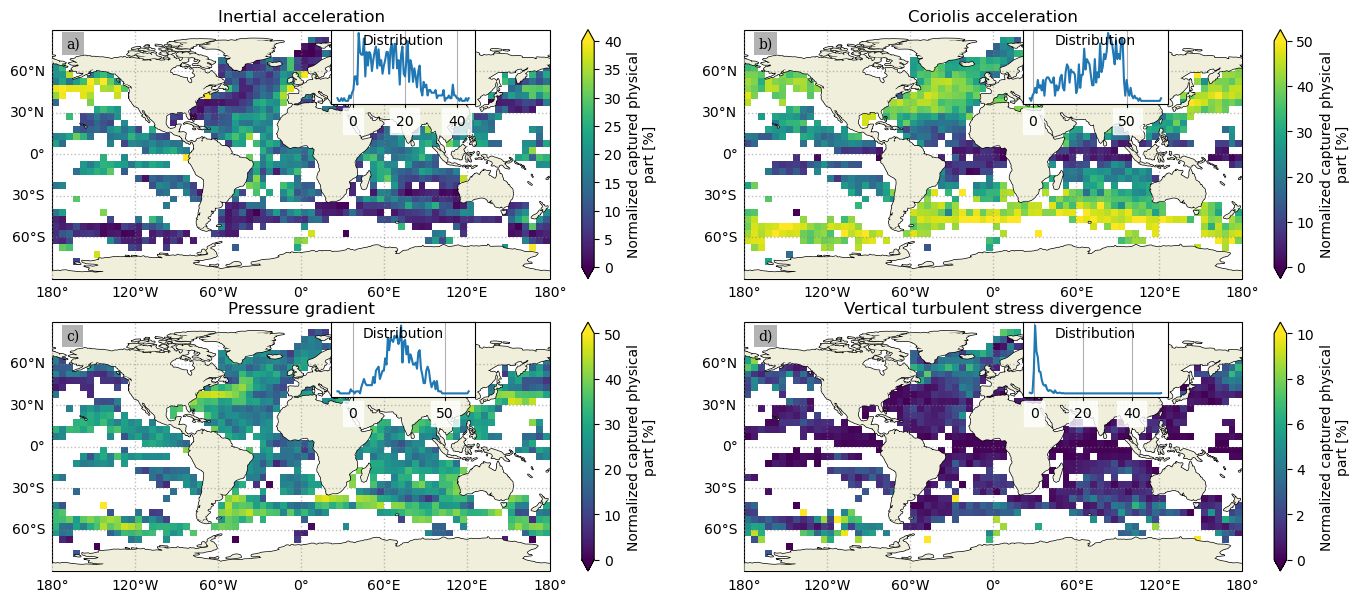

In [248]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True)
axs=axs.flatten()
label = 'Normalized captured physical part'

ax=axs[0]
dsmssco_s['true_acc'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_acc'], ax, 'a', vmin = 0, vmax=40)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco_s['true_coriolis'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_coriolis'], ax, 'b', vmin = 0, vmax=50)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco_s['true_ggrad'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_ggrad'], ax, 'c', vmin = 0, vmax=50)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco_s['true_wind'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_wind'], ax, 'd', vmin = 0, vmax=10)
ax.set_title('Vertical turbulent stress divergence')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)


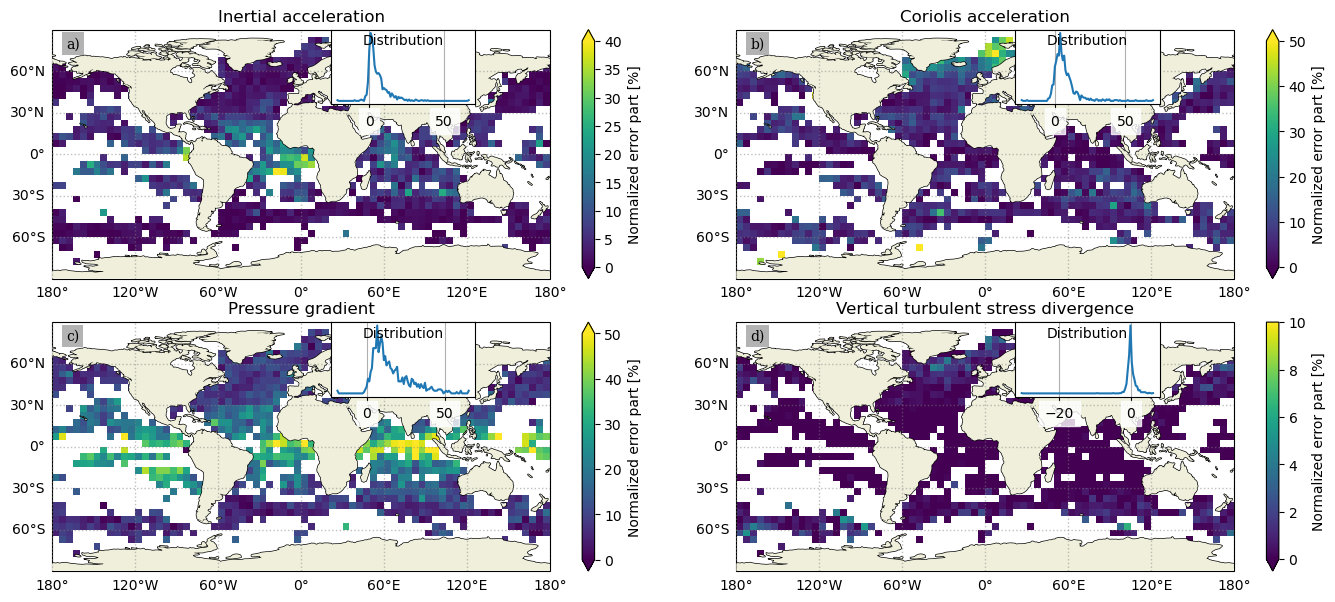

In [249]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True)
axs=axs.flatten()
label = 'Normalized error part'

ax=axs[0]
dsmssco_s['err_acc'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_acc'], ax, 'a', vmin = 0, vmax=40)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco_s['err_coriolis'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_coriolis'], ax, 'b', vmin = 0, vmax=50)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco_s['err_ggrad'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_ggrad'], ax, 'c', vmin = 0, vmax=50)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco_s['err_wind'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_wind'], ax, 'd', vmin = 0, vmax=10)
ax.set_title('Vertical turbulent stress divergence')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)


______________________
# $\alpha$ contribution : $C_{\alpha} = \langle S_{-\alpha}^2\rangle-\langle S^2 \rangle$
## Under H1 :

In [63]:
def plot_stat_lonlat(variables, ds=1, cmap='viridis', title =1 , cmap_label =1 ,fig_title=1,**kwargs):
    lv = len(variables)
    if isinstance(variables[0],str):
        variables = [ds[v] for v in variables]
        if isinstance(ds, int) : 
            assert False, 'give dataset'
    nrows = int(np.ceil(lv/2))
    ncols = 2
    if lv == 1:
        nrows = 1
        ncols = 1
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(14,6))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    if lv !=1:
        axs=axs.flatten()
    else : axs = [axs]

    #Loop over all of the variables
    for i in range(lv):

            # Contour plot
            if cmap_label != 1:
                variables[i].assign_attrs({'long_name':cmap_label[i]}).plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i],**kwargs)

            else : 
                variables[i].plot(x='lonbin', y='latbin', cmap=cmap, ax=axs[i], **kwargs)
            
            # Title each subplot with the name of the model
            if title != 1:
                axs[i].set_title(title[i], fontsize=14)

    for ax in axs:
        ax.coastlines()
        ax.add_feature(cfeature.LAND, zorder=10)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=11)
        gl.xlabels_top = False
        gl.ylabels_right = False
    if isinstance(fig_title, str):
        fig.suptitle(fig_title)
    fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
    # Delete the unwanted axes
    if lv !=1:
        for i in np.arange(lv,nrows*2):
            fig.delaxes(axs[i])

In [84]:
def plot_ms_lonlat(variables, ds, id_, dic, title=1, **kwargs):
    ticks = [r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', "$fv_{Ekman}$"]
    plot_stat_lonlat(variables, ds=ds, title = [ticks[i] for i in range(len(ticks))], **kwargs)

In [85]:
def C_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        c_x = xr.Dataset()
        for l in lab :
            c_x[l] = ds['exc_'+l+'_'+id_] - ds['sum_'+id_]
    return c_x
CX = xr.concat([C_x(dsm, id_co, dic = id_co_dic), C_x(dsm, id_co, dic = id_co_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb'))
for v in ['acc', 'coriolis', 'ggrad', 'wind']: 
    CX[v].attrs = {'long_name':r'Contribution $C_{\alpha}$', 'unit':r'$m^2/s^4$'}

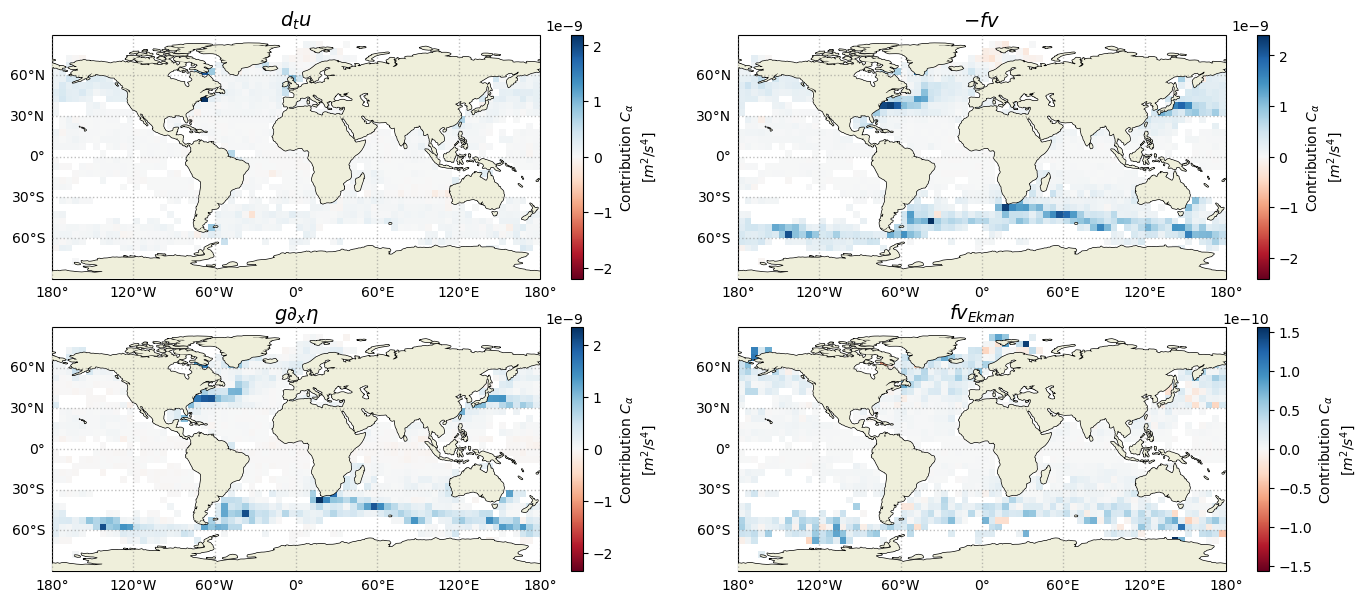

In [86]:
plot_ms_lonlat(['acc', 'coriolis', 'ggrad', 'wind'],CX.sel(id_comb =id_co), id_co, id_co_dic, cmap = 'RdBu', )